# Imports and Functions

In [37]:
import numpy as np
import math
from matplotlib import pyplot as plt
import scipy.stats as st

In [38]:
def buildTree(S, vol , T, N):
    dt = T / N
    matrix = np.zeros((N + 1, N + 1))
    u = np.exp(vol*np.sqrt(dt))
    d = np.exp(-vol*np.sqrt(dt))
    # Iterate over the lower triangle
    for i in np.arange(N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            # Find matrix entry after i down and j up moves
            matrix[i, j] = S * u**j * d**(i-j)
    return matrix

def valueOptionMatrix(tree , T, r , K, vol, N, complexity=False, kind='Call'):
    dt = T / N
    u = np.exp(vol*np.sqrt(dt))
    d = np.exp(-vol*np.sqrt(dt))
    p = (np.exp(r*dt) -d) / (u - d)
    columns = tree.shape[1]
    rows = tree.shape[0]
    if complexity == True:
        comp = 0
    # Walk backward , we start in last row of the matrix
    # Add the payoff function in the last row
    for c in np.arange(columns):
        S_t = tree[rows - 1, c] # value in the matrix
        if kind == 'Call':
            tree[rows - 1, c] = max(0, S_t - K)
        else:
            tree[rows - 1, c] = max(0, K - S_t)
    # For all other rows, we need to combine from previous rows 
    # We walk backwards, from the last row to the first row
    for i in np.arange(rows - 1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            tree[i, j] = np.exp(-r*dt) * (p * up + (1 - p) * down)
            if complexity == True:
                comp += 1
    if complexity == True:
        return tree, comp
    else:
        return tree

def AmericanValueOptionMatrix(tree , T, r , K, vol, N, kind='Call'):
    dt = T / N
    u = np.exp(vol*np.sqrt(dt))
    d = np.exp(-vol*np.sqrt(dt))
    p = (np.exp(r*dt) -d) / (u - d)
    columns = tree.shape[1]
    rows = tree.shape[0]
    # Walk backward , we start in last row of the matrix
    # Add the payoff function in the last row
    for c in np.arange(columns):
        S_t = tree[rows - 1, c] # value in the matrix
        if kind == 'Call':
            tree[rows - 1, c] = max(0, S_t - K)
        else:
            tree[rows - 1, c] = max(0, K - S_t)
    # For all other rows, we need to combine from previous rows 
    # We walk backwards, from the last row to the first row
    for i in np.arange(rows - 1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            continue_val = np.exp(-r*dt) * (p * up + (1 - p) * down)
            if kind == 'Call':
                exercise_val = tree[i, j] - K
            else:
                exercise_val = K - tree[i, j]
            tree[i, j] = max(exercise_val, continue_val)
    return tree

def callPrice(tree):
    return tree[0][0]

# 2.1 Build the tree and evaluate the call option price with N = 50

In [39]:
# Given input values
sigma = 0.2
S = 100
T = 1.
N = 50
K = 99
r = 0.06

# Create binomial tree
tree = buildTree(S, sigma, T, N)

# Create value option price matrix
option_matrix = valueOptionMatrix(tree.copy(), T, r, K, sigma, N)
print("Matrix:\n", option_matrix)

# Price the call option price approximation now
price_option = option_matrix[0][0]
print("Approximated option price:", price_option)

Matrix:
 [[ 11.54643485   0.           0.         ...   0.           0.
    0.        ]
 [  9.60391567  13.40897969   0.         ...   0.           0.
    0.        ]
 [  7.86799392  11.26670021  15.46463735 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 289.94017906   0.
    0.        ]
 [  0.           0.           0.         ... 278.98144103 300.9727274
    0.        ]
 [  0.           0.           0.         ... 268.32487093 289.70286396
  312.32503788]]
Approximated option price: 11.546434850755071


The price of the option is therefore 11.54643

# 2.2 Binomial Tree compared to Balck Scholes for different volatilities

In [40]:
# Compare estimate of Black Scholes to the Binomial Tree value
S = 100
T = 1.
N = 50
K = 99
r = 0.06
sigma = 0.2

# Computation of the Black Scholes Analytical Price for the Call Option
d1 = (np.log(S/K) + (r + 1/2 * sigma ** 2) * T)/(sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
BS_V = S * st.norm.cdf(d1) - np.exp(-r * T) * K * st.norm.cdf(d2)

# Calculate the option price for the correct parameters 
tree = buildTree(S, sigma, T, N)
tree_V = valueOptionMatrix (tree.copy(), T, r, K, sigma, N)[0][0]

# Print outcomes
print("Black Scholes:", BS_V)
print("Binomial Tree:", tree_V)
print("Difference (Tree - BS):", tree_V - BS_V)

Black Scholes: 11.544280227051097
Binomial Tree: 11.546434850755071
Difference (Tree - BS): 0.0021546237039746785


In [41]:
S = 100
T = 1.
N = 50
K = 99
r = 0.06

vol = np.linspace(0.1, 10, num=100)
BS_value = []; tree_value = []

for sigma in vol:
    # Computation of the Black Scholes Analytical Price for the Call Option
    d1 = (np.log(S/K) + (r + 1/2 * sigma ** 2) * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    BS_V = S * st.norm.cdf(d1) - np.exp(-r * T) * K * st.norm.cdf(d2)
    BS_value.append(BS_V)

    # Calculate the option price for the correct parameters 
    tree = buildTree(S, sigma, T, N)
    tree_V = valueOptionMatrix (tree.copy(), T, r, K, sigma, N)[0][0]
    tree_value.append(tree_V)

    # Only print the values each 100% of volatility
    if sigma % 1 == 0 or sigma < 1:
        print("Volatility = ", sigma)
        print("Black Scholes:", BS_V)
        print("Binomial Tree:", tree_V)
        print("Difference (Tree - BS):", tree_V - BS_V)

Volatility =  0.1
Black Scholes: 8.142778224593997
Binomial Tree: 8.149874356970908
Difference (Tree - BS): 0.007096132376911868
Volatility =  0.2
Black Scholes: 11.544280227051097
Binomial Tree: 11.546434850755071
Difference (Tree - BS): 0.0021546237039746785
Volatility =  0.30000000000000004
Black Scholes: 15.213003219921596
Binomial Tree: 15.200663216397928
Difference (Tree - BS): -0.012340003523668486
Volatility =  0.4
Black Scholes: 18.929417003352384
Binomial Tree: 18.900090275449024
Difference (Tree - BS): -0.029326727903359995
Volatility =  0.5
Black Scholes: 22.63907067172252
Binomial Tree: 22.591847460113826
Difference (Tree - BS): -0.04722321160869569
Volatility =  0.6
Black Scholes: 26.317666660040445
Binomial Tree: 26.252196855607547
Difference (Tree - BS): -0.0654698044328974
Volatility =  0.7000000000000001
Black Scholes: 29.949987184124268
Binomial Tree: 29.86619215294056
Difference (Tree - BS): -0.08379503118370835
Volatility =  0.8
Black Scholes: 33.52452653168218
Bin

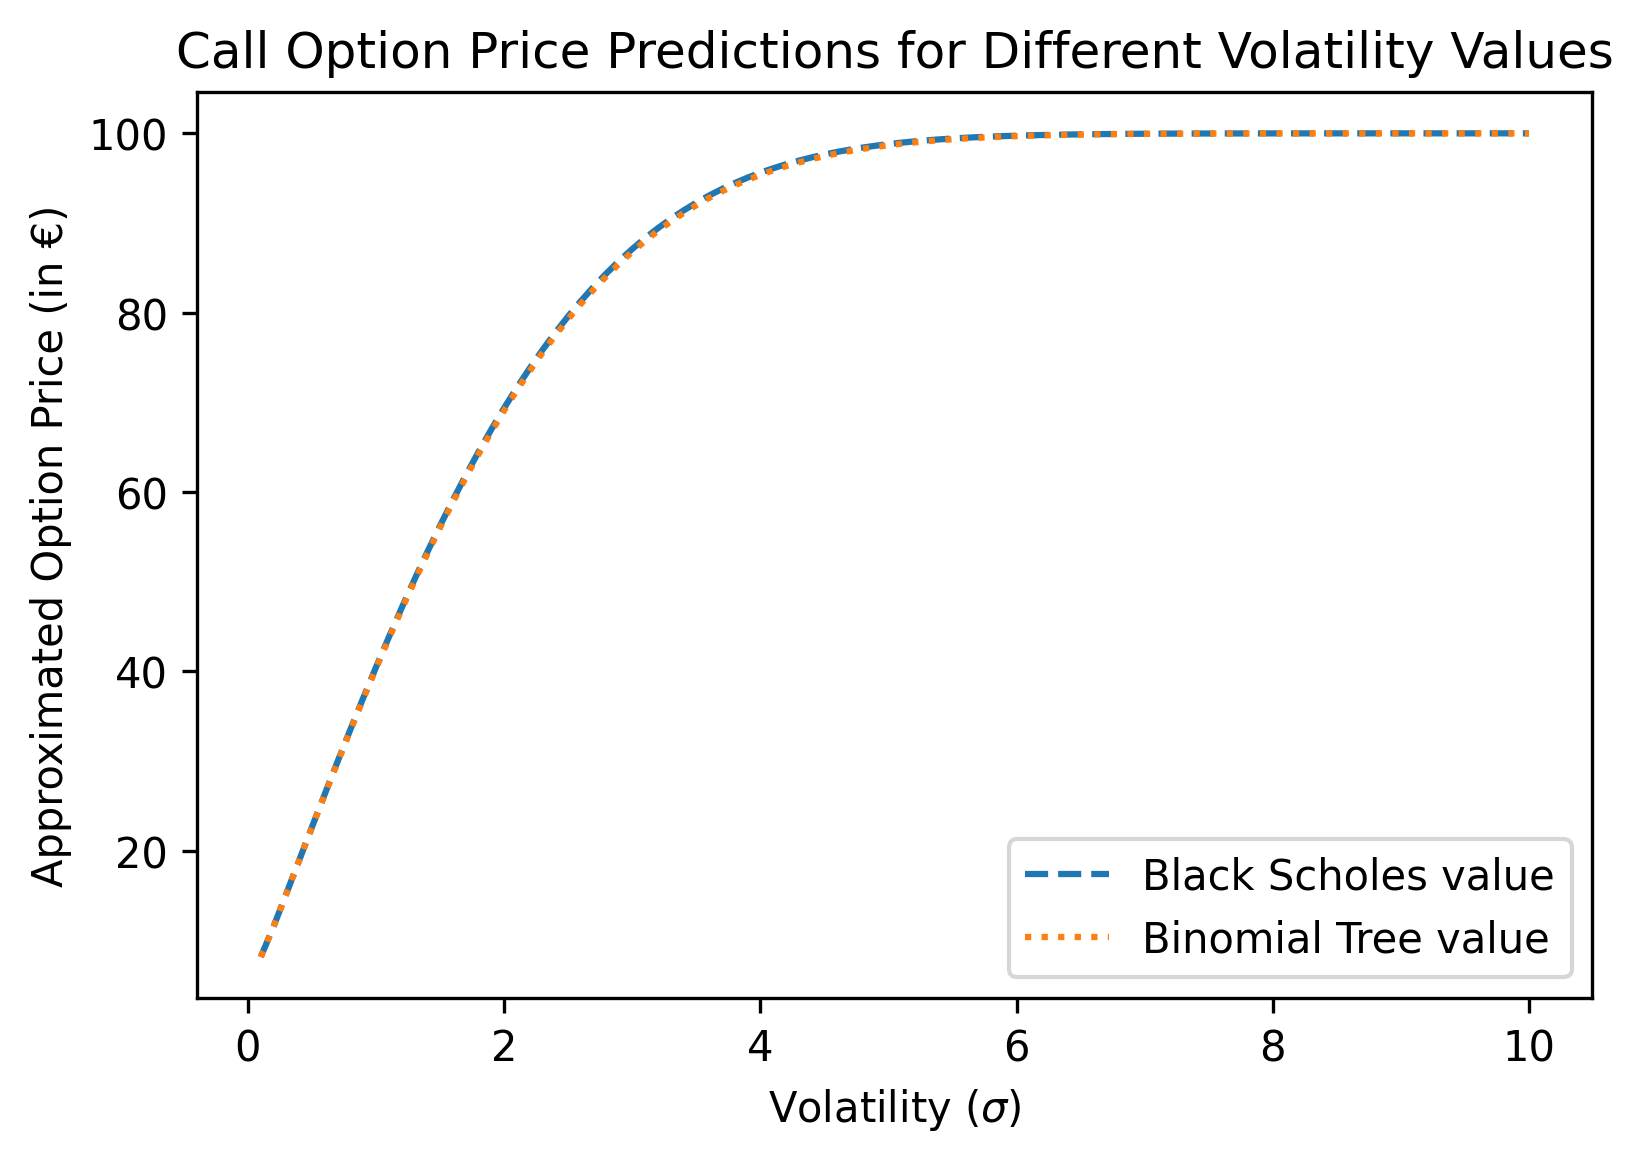

In [42]:
# Make figure
plt.figure(dpi=300)
plt.plot(vol, BS_value, linestyle="dashed", label="Black Scholes value")
plt.plot(vol, tree_value, linestyle="dotted", label="Binomial Tree value")
plt.xlabel(r"Volatility ($\sigma$)")
plt.ylabel("Approximated Option Price (in €)")
plt.legend()
plt.title("Call Option Price Predictions for Different Volatility Values")
plt.show()

# 2.3 Convergence for increasing number of steps in the binomial tree

11.546434850755071


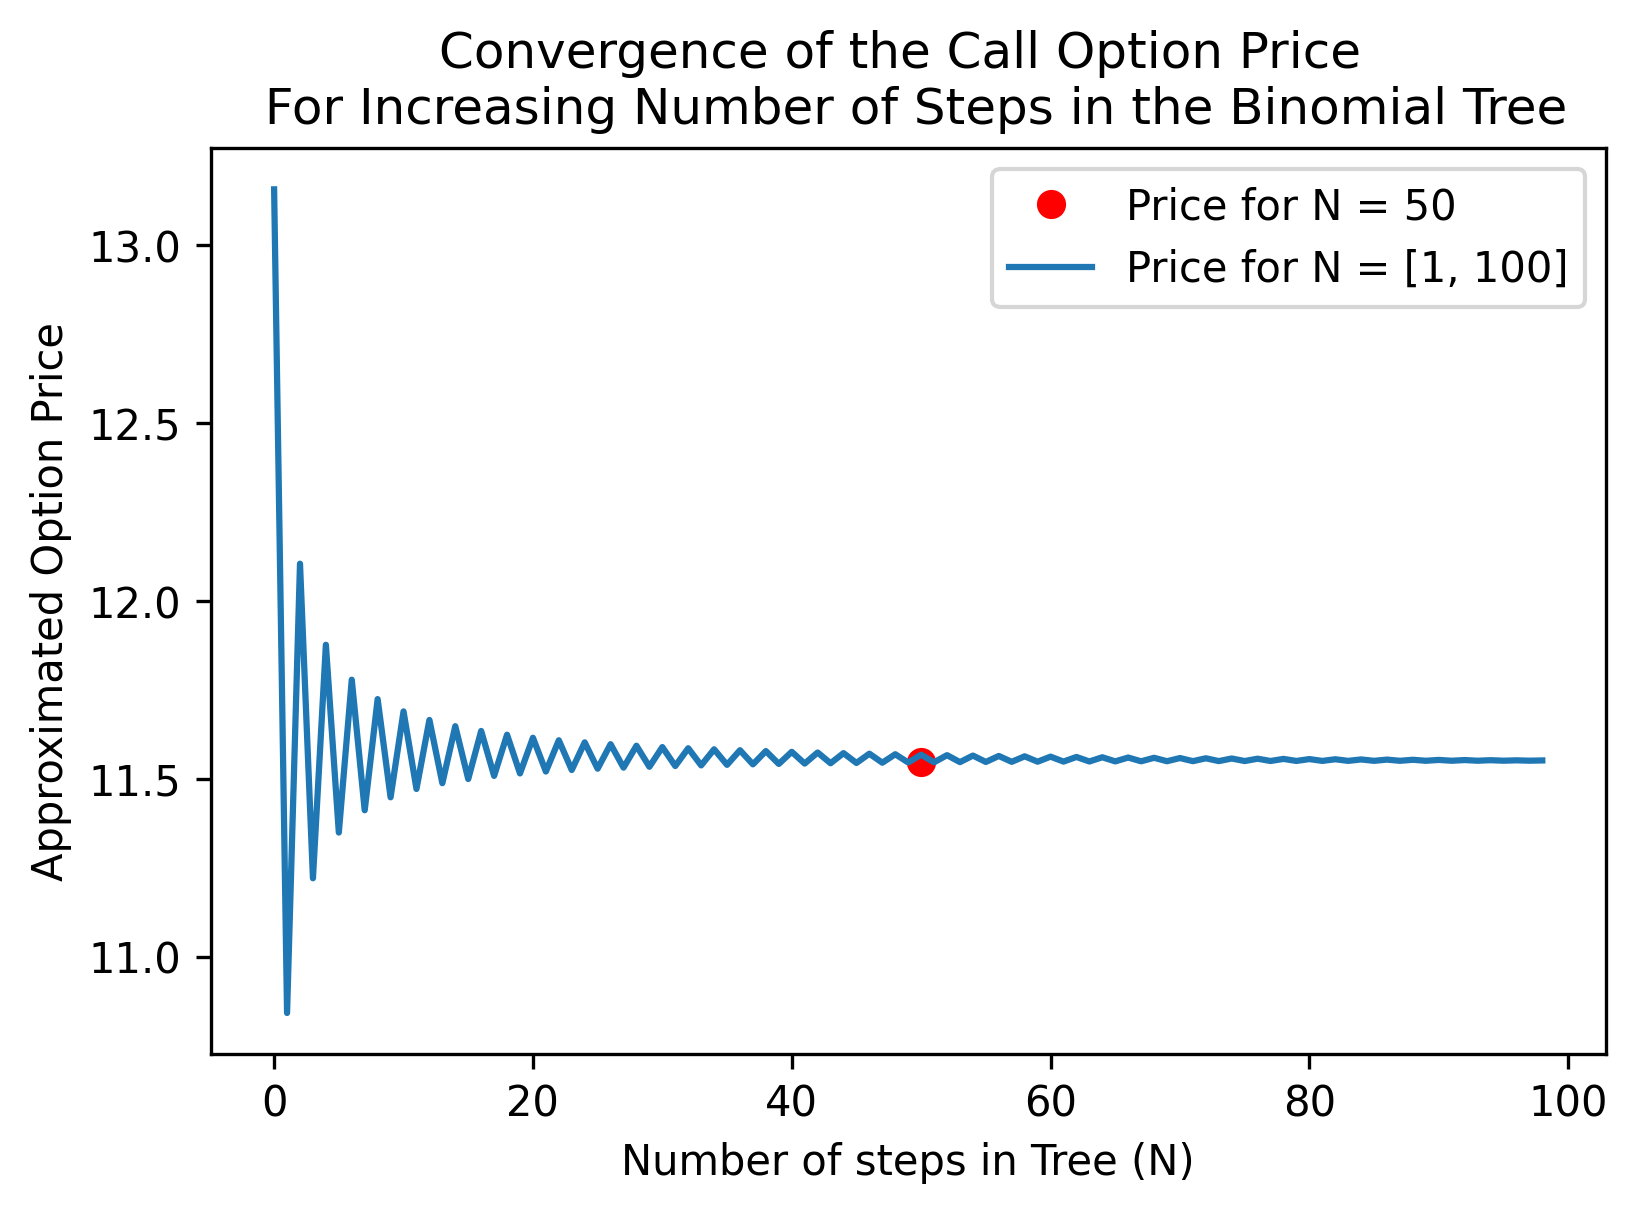

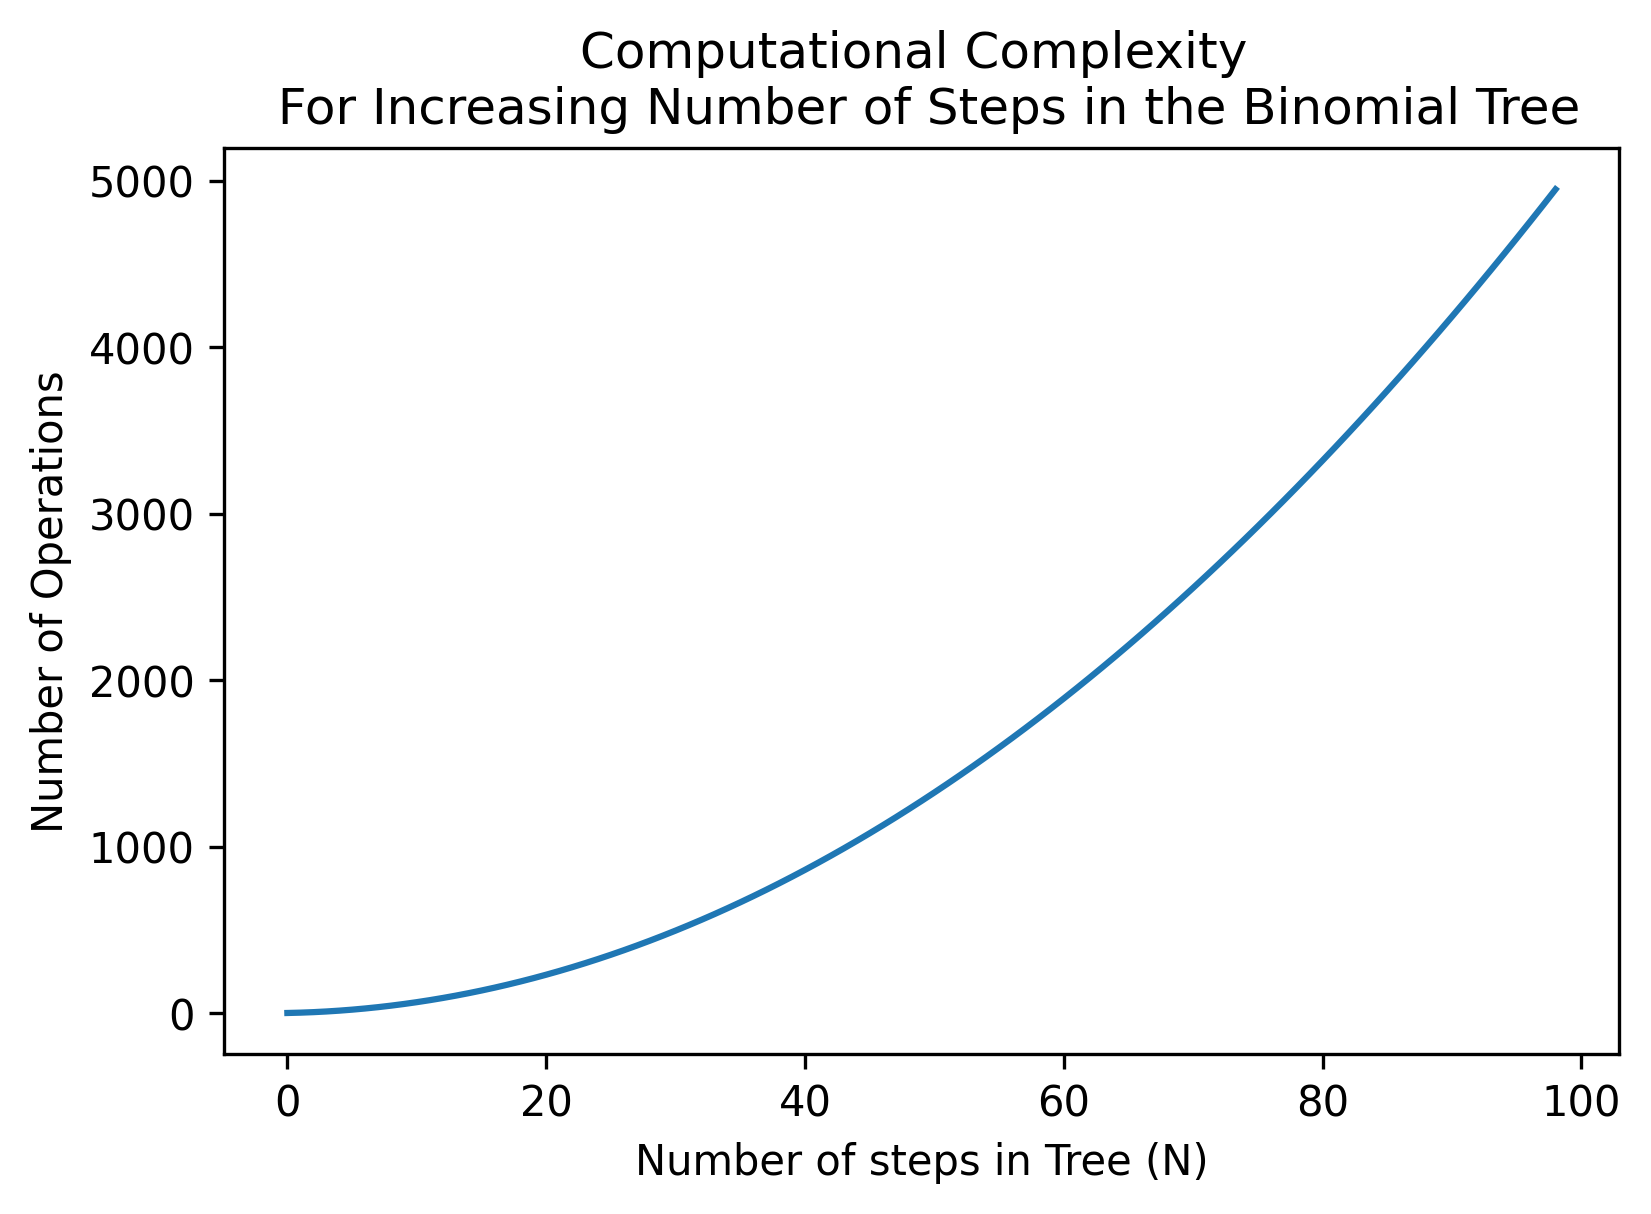

In [43]:
# Calculate the option price for the correct parameters 
S = 100
T = 1.
N = 50
K = 99
r = 0.06
sigma = 0.2
tree = buildTree(S, sigma, T, N)
optionPriceAnalytical = valueOptionMatrix(tree.copy(), T, r, K, sigma, N)[0][0]

print(optionPriceAnalytical)

# Play around with different ranges of N and step sizes. 
N = 100
price_approxs = []; comp_complex = []

# calculate option price for each n in N 
for n in range(1, N):
    treeN = buildTree(S, sigma, T, n)
    matrix, comp = valueOptionMatrix(treeN.copy(), T, r, K, sigma, n, complexity=True)
    price_approx = callPrice(matrix)
    comp_complex.append(comp)
    price_approxs.append(price_approx)

# Plot convergence call option price
plt.figure(dpi=300)
plt.plot(50, optionPriceAnalytical, 'ro', label="Price for N = 50")
plt.plot(price_approxs, label="Price for N = [1, 100]")
plt.xlabel("Number of steps in Tree (N)")
plt.ylabel("Approximated Option Price")
plt.title("Convergence of the Call Option Price \n For Increasing Number of Steps in the Binomial Tree")
plt.legend()
plt.show()

# Plot computational complexity
plt.figure(dpi=300)
plt.plot(comp_complex)
plt.xlabel("Number of steps in Tree (N)")
plt.ylabel("Number of Operations")
plt.title("Computational Complexity \n For Increasing Number of Steps in the Binomial Tree")
plt.show()

# 2.4 Hedge parameter comparison between Binomial Tree and Black Scholes for different volatilies

In [44]:
# Binomial Tree delta
n = 50
tree = buildTree(S, sigma, T, n)
Su = tree[1][0]
Sd = tree[1][1]
optionPrice = valueOptionMatrix(tree.copy(), T, r, K, sigma, n)
fu = optionPrice[1][0]
fd = optionPrice[1][1]
delta_BT = (fu - fd)/(Su - Sd)
print(fu, fd, Su, Sd)
print("delta = ", delta_BT)

9.603915673337555 13.408979691108888 97.21119840328973 102.86880693018583
delta =  0.6725569646047751


In [45]:
# Black-Scholes delta ∆0 = N(d1)
S = 100
T = 1.
N = 50
K = 99
r = 0.06
sigma = 0.2
d1 = (np.log(S/K) + (r + 1/2 * sigma ** 2) * T)/(sigma * np.sqrt(T))
delta_BS = st.norm.cdf(d1)
print("delta = ", delta_BS)

delta =  0.6737355117348961


In [46]:
print("Difference =", delta_BT - delta_BS)

Difference = -0.0011785471301209993


In [47]:
# Experimenting with different volatility values for the Binomial Tree
BS_deltas = []; tree_deltas = []
S = 100
T = 1.
K = 99
r = 0.06
N = 50

vol = np.linspace(0.05, 10, num=399)
for sigma in vol:
    tree = buildTree(S, sigma, T, n)
    Su = tree[1][0]
    Sd = tree[1][1]
    optionPrice = valueOptionMatrix(tree.copy(), T, r, K, sigma, N)
    fu = optionPrice[1][0]
    fd = optionPrice[1][1]
    delta_tree = (fu - fd)/(Su - Sd)
    tree_deltas.append(delta_tree)

    d1 = (np.log(S/K) + (r + 1/2 * sigma ** 2) * T)/(sigma * np.sqrt(T))
    delta_BS = st.norm.cdf(d1)
    BS_deltas.append(delta_BS)
    if sigma % 1 == 0 or sigma < 1:
        print("Volatility = ", sigma)
        print("Binomial Tree delta = ", delta_tree)
        print("Black Scholes delta = ", delta_BS)

Volatility =  0.05
Binomial Tree delta =  0.9220202041144163
Black Scholes delta =  0.9230667984188915
Volatility =  0.075
Binomial Tree delta =  0.8319706433108561
Black Scholes delta =  0.8343514378640482
Volatility =  0.1
Binomial Tree delta =  0.7712583997882323
Black Scholes delta =  0.7735241991048447
Volatility =  0.125
Binomial Tree delta =  0.7314020029057934
Black Scholes delta =  0.7333257638470051
Volatility =  0.15
Binomial Tree delta =  0.7044791575273822
Black Scholes delta =  0.7060915182785574
Volatility =  0.175
Binomial Tree delta =  0.6857833143717301
Black Scholes delta =  0.6871498641336622
Volatility =  0.2
Binomial Tree delta =  0.6725569646047751
Black Scholes delta =  0.6737355117348961
Volatility =  0.22499999999999998
Binomial Tree delta =  0.6631215615905193
Black Scholes delta =  0.6641568611099056
Volatility =  0.25
Binomial Tree delta =  0.656409501958188
Black Scholes delta =  0.6573352412027771
Volatility =  0.27499999999999997
Binomial Tree delta =  0

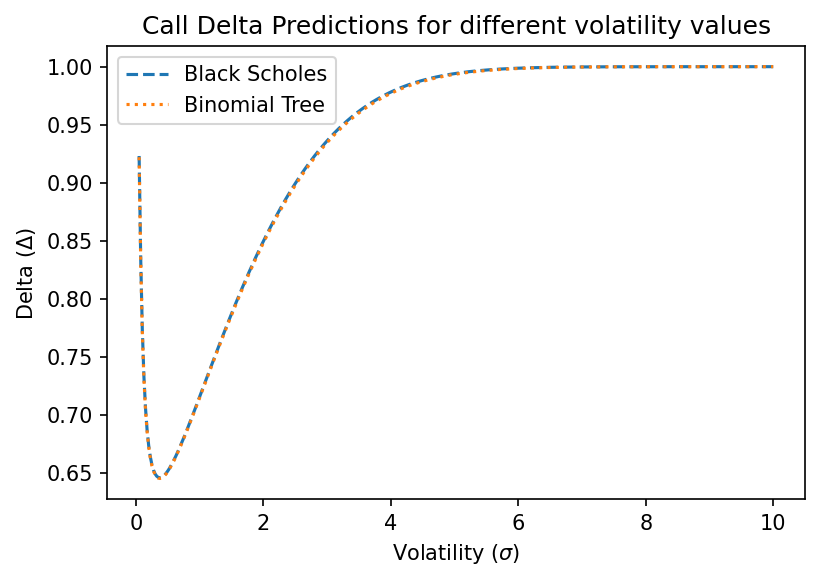

In [48]:
# Make figure
plt.figure(dpi=150)
plt.plot(vol, BS_deltas, linestyle="dashed", label="Black Scholes")
plt.plot(vol, tree_deltas, linestyle="dotted", label="Binomial Tree")
plt.xlabel(r"Volatility ($\sigma$)")
plt.ylabel(r"Delta ($\Delta$)")
plt.legend()
plt.title("Call Delta Predictions for different volatility values")
plt.show()

In [69]:
# Function to construct a binary tree
# from specified ancestor matrix
def constructBT(mat):

    # get number of rows in the matrix
    N = len(mat)
 
    for i in range(N):
        space = " "*int((N - i)*(9/2))
        line = space
        for j in range(0, i + 1):
            price = str(round(mat[i][j], 5))
            line += price + " "*(9 - len(price))
            line += '\n'
        print(line)

# Print the binomial tree
S = 100
T = 1.
K = 99
r = 0.06
sigma = 0.2
n = 2
tree = buildTree(S, sigma, T, n)
option_matrix = valueOptionMatrix(tree.copy(), T, r, K, sigma, n)
constructBT(option_matrix)

             10.84258 

         0.55511  
19.11688 

    0.0      
1.0      
33.68964 



# 2.5 Comparing European Put and Call Option Price Approximations with American Option Approximations

In [50]:
S = 100
T = 1.
N = 50
K = 99
r = 0.06
sigma = 0.2
tree = buildTree(S, sigma, T, N)
Amer_call_price = AmericanValueOptionMatrix(tree.copy(), T, r, K, sigma, N, kind='Call')[0][0]
Amer_put_price = AmericanValueOptionMatrix(tree.copy(), T, r, K, sigma, N, kind='Put')[0][0]
Euro_call_price = valueOptionMatrix(tree.copy(), T, r, K, sigma, N, kind='Call')[0][0]
Euro_put_price = valueOptionMatrix(tree.copy(), T, r, K, sigma, N, kind='Put')[0][0]

print(Amer_call_price, Amer_put_price)
print(Euro_call_price, Euro_put_price)

11.546434850755071 5.347763498417651
11.546434850755071 4.7811236755959206


Volatility =  0.05
Call
European call price 6.939838639622885
American call price 6.939838639622885
Put
European put price 0.17452746446372194
American put price 0.41185718637817265
--------------------
Volatility =  0.075
Call
European call price 7.451859461917632
American call price 7.451859461917632
Put
European put price 0.6865482867584682
American put price 1.0718968789193866
--------------------
Volatility =  0.1
Call
European call price 8.149874356970908
American call price 8.149874356970908
Put
European put price 1.3845631818117392
American put price 1.8503181429508089
--------------------
Volatility =  0.125
Call
European call price 8.941009933151225
American call price 8.941009933151225
Put
European put price 2.1756987579920617
American put price 2.6844018429919574
--------------------
Volatility =  0.15
Call
European call price 9.783050411398213
American call price 9.783050411398213
Put
European put price 3.0177392362390645
American put price 3.5544436070680785
-------------

Volatility =  10.0
Call
European call price 99.99983884348181
American call price 99.99983884348181
Put
European put price 93.23452766832244
American put price 97.94500519637724
--------------------


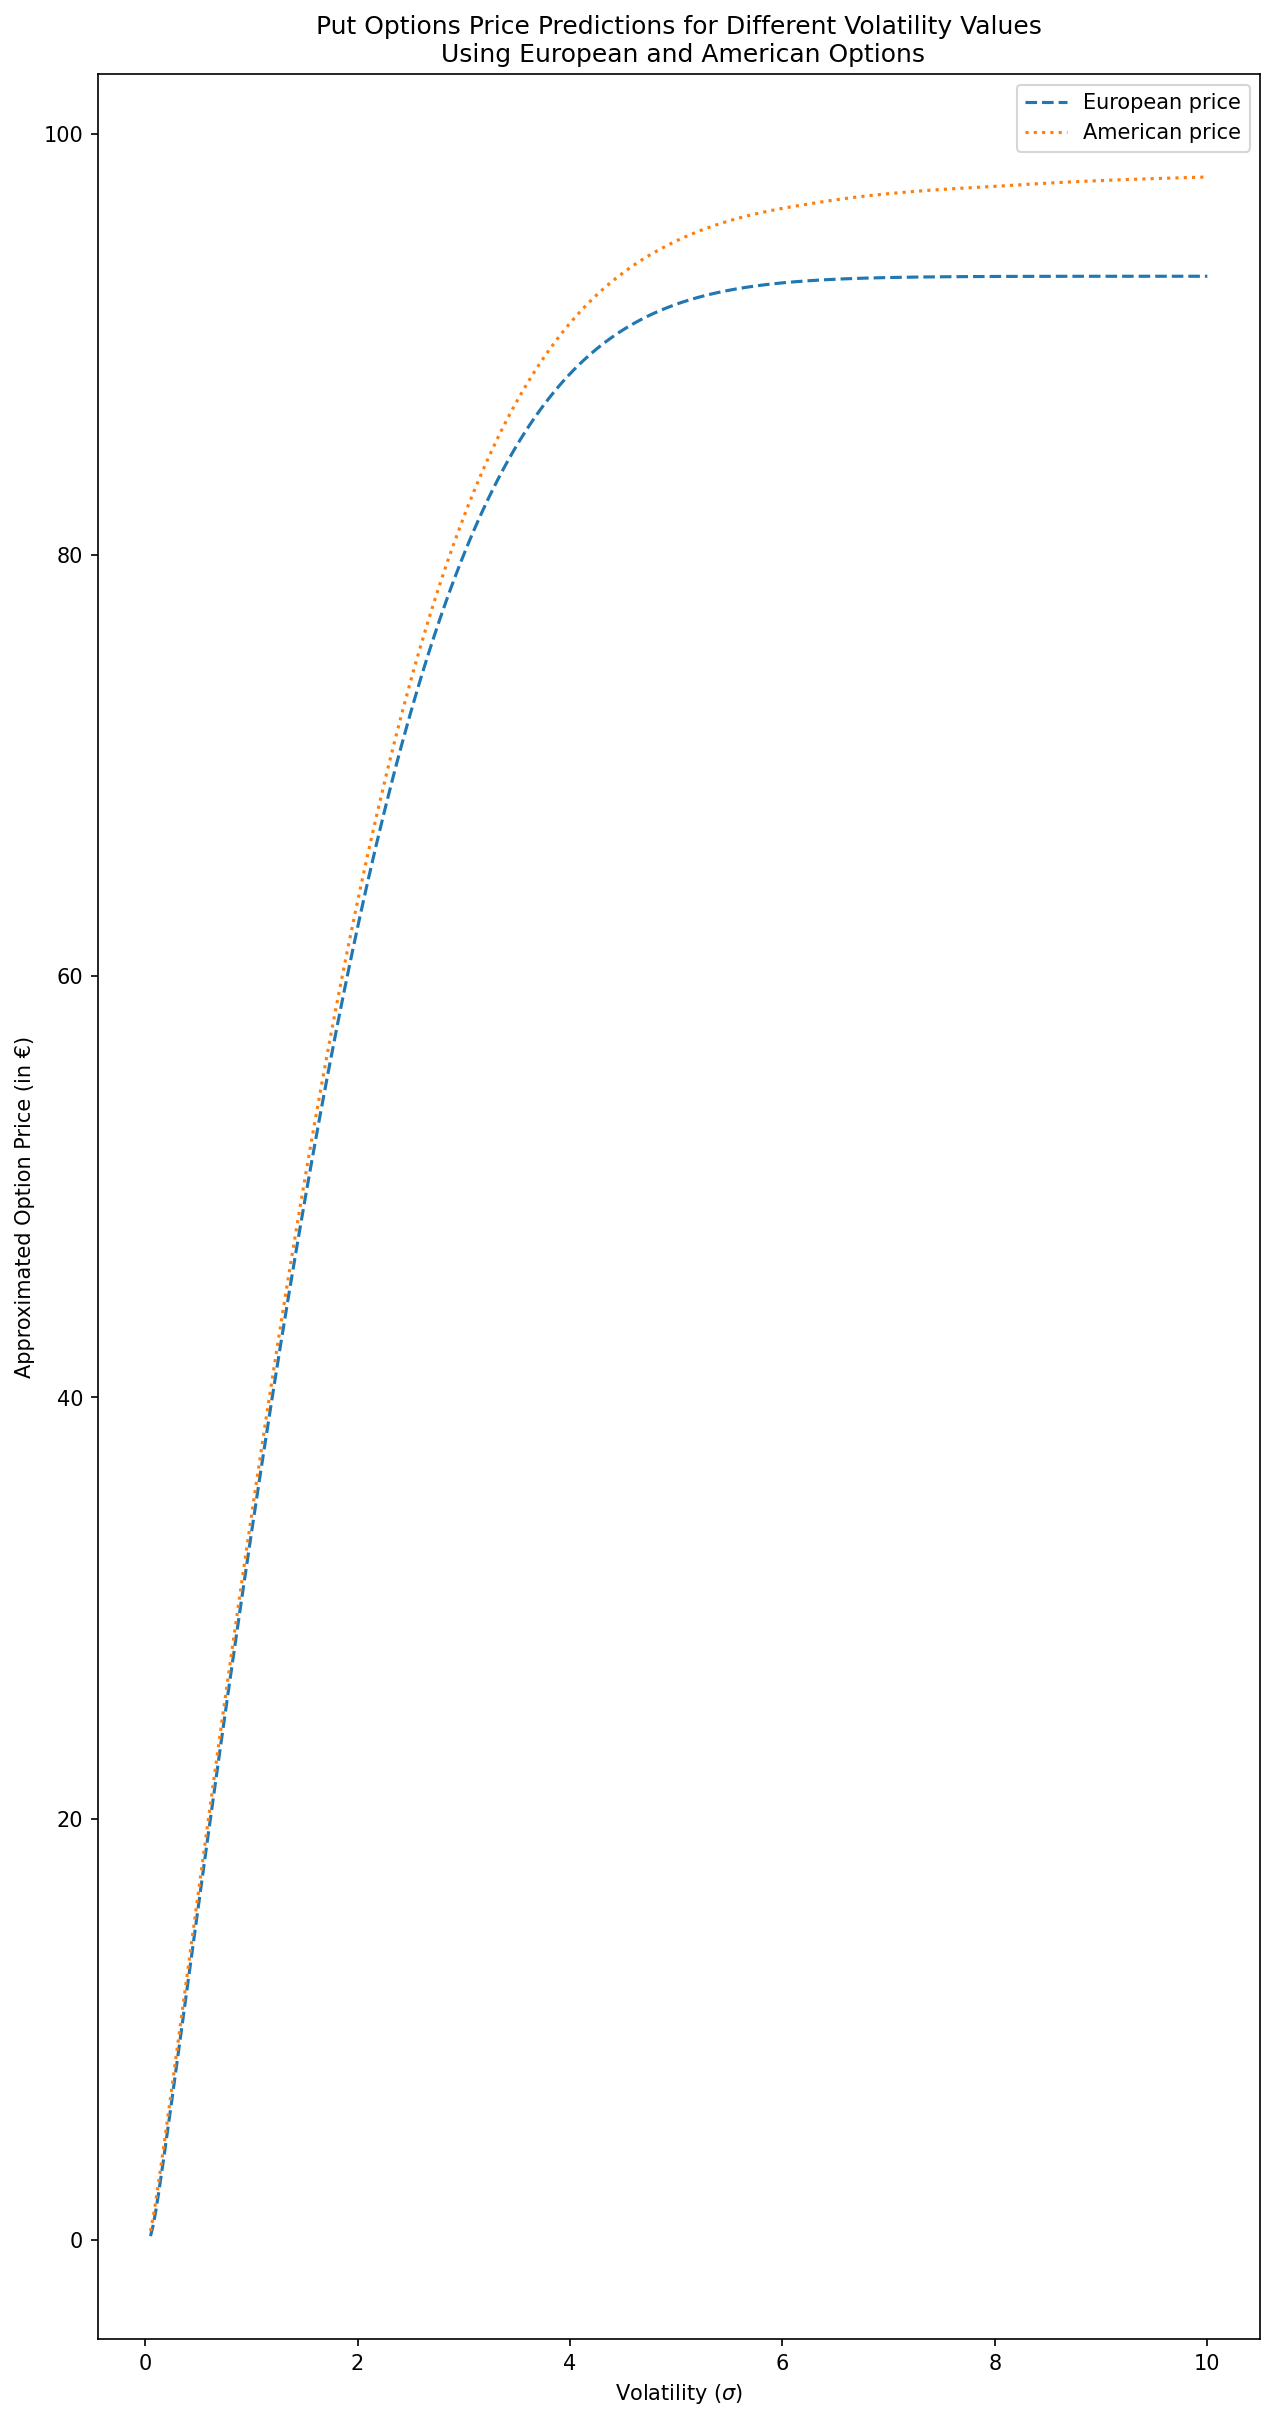

In [53]:
# Experimenting with different volatility values
S = 100
T = 1.
K = 99
r = 0.06
N = 50

Euro_call_prices = []; Amer_call_prices = []
Euro_put_prices = []; Amer_put_prices = []

vol = np.linspace(0.05, 10, num=399)
for sigma in vol:
    tree = buildTree(S, sigma, T, N)
    Euro_call_price = valueOptionMatrix(tree.copy(), T, r, K, sigma, N)[0][0]
    Euro_call_prices.append(Euro_call_price)

    Amer_call_price = AmericanValueOptionMatrix(tree.copy(), T, r, K, sigma, N)[0][0]
    Amer_call_prices.append(Amer_call_price)

    if sigma % 1 == 0 or sigma < 1:
        print("Volatility = ", sigma)
        print("Call")
        print("European call price", Euro_call_price)
        print("American call price", Amer_call_price)

    Euro_put_price = valueOptionMatrix(tree.copy(), T, r, K, sigma, N, kind='Put')[0][0]
    Euro_put_prices.append(Euro_put_price)

    Amer_put_price = AmericanValueOptionMatrix(tree.copy(), T, r, K, sigma, N, kind='Put')[0][0]
    Amer_put_prices.append(Amer_put_price)

    if sigma % 1 == 0 or sigma < 1:
        print('Put')
        print("European put price", Euro_put_price)
        print("American put price", Amer_put_price)
        print('-'*20)

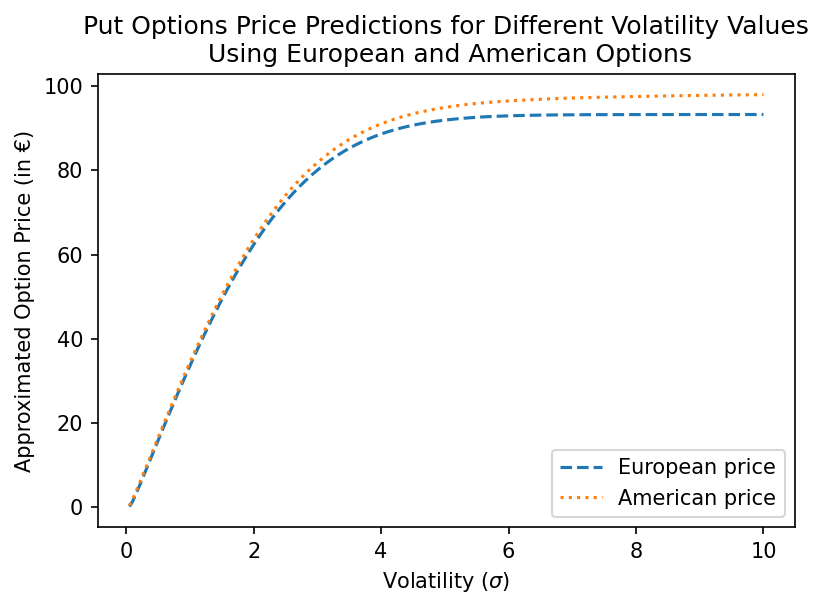

In [57]:
# Make figure
plt.figure(dpi=150)
plt.plot(vol, Euro_put_prices, linestyle="dashed", label="European price")
plt.plot(vol, Amer_put_prices, linestyle="dotted", label="American price")
plt.xlabel(r"Volatility ($\sigma$)")
plt.ylabel(r"Approximated Option Price (in €)")
plt.legend()
plt.title("Put Options Price Predictions for Different Volatility Values\n Using European and American Options")
plt.show()